In [1]:
import numpy as np
import copy
from tqdm import tqdm
from scipy.optimize import curve_fit
from uncertainties import ufloat
import h5py
import os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# Lattice class

In [2]:
class Lattice:
    def __init__(self, N, d, k, l):
        self.N = N
        self.d = d
        self.shape = [N for _ in range(d)]
        self.k = k
        self.l = l

        self.phi = np.random.randn(*self.shape)
        self.action = self.get_action()

    def get_action(self):
        action = (1 - 2 * self.l) * self.phi**2 + self.l * self.phi**4

        for mu in range(self.d):
            action += -2. * self.k * self.phi * np.roll(self.phi, 1, mu)

        return action.sum()

    def get_local_action(self, xyz):
        action = (1 - 2 * self.l) * self.phi[xyz]**2 + self.l * self.phi[xyz]**4

        for mu in range(self.d):
            hop = np.zeros((self.d, 1), dtype=int)
            hop[mu,0] = 1
            xyz_plus = tuple(map(tuple, ((np.array(xyz) + hop) % self.N)))
            xyz_minus = tuple(map(tuple, ((np.array(xyz) - hop) % self.N)))
            action += -2. * self.k * self.phi[xyz] * (self.phi[xyz_plus] + self.phi[xyz_minus])

        return action

    def get_drift(self):
        drift = 2 * self.phi * (2 * self.l * (1 - self.phi**2) - 1)

        for mu in range(self.d):
            drift += 2. * self.k * (np.roll(self.phi, 1, mu) + np.roll(self.phi, -1, mu))

        return drift

    def get_hamiltonian(self, chi, action):
        return 0.5 * np.sum(chi**2) + action

    def metropolis(self, sigma=1.):
        xyz = tuple(map(tuple, np.random.randint(0, self.N, (self.d,1))))
        phi_0 = self.phi[xyz]
        S_0 = self.get_local_action(xyz)

        self.phi[xyz] += sigma * np.random.randn()

        dS = self.get_local_action(xyz) - S_0

        if dS > 0:
            if np.random.rand() >= np.exp(-dS):
                self.phi[xyz] = phi_0

                return False
        return True

    def langevin(self, dt=0.01):
        chi = np.random.randn(*self.shape)

        self.phi += (dt * self.get_drift() +
                     np.sqrt(dt) * chi)

        return True

    def hmc(self, n_steps=100):
        dt = 1 / n_steps
        phi_0 = copy.deepcopy(self.phi)
        chi = np.random.randn(*self.shape)

        S_0 = self.action
        H_0 = self.get_hamiltonian(chi, S_0)

        chi += 0.5 * dt * self.get_drift()

        for i in range(n_steps):
            self.phi += dt * chi

            if i == n_steps-1:
                chi += 0.5 * dt * self.get_drift()
            else:
                chi += dt * self.get_drift()

        self.action = self.get_action()
        dH = self.get_hamiltonian(chi, self.action) - H_0

        if dH > 0:
            if np.random.rand() >= np.exp(-dH):
                self.phi = phi_0
                self.action = S_0

                return False
        return True

# Functions from previous notebook (get jackknife mean, get different observables)

In [3]:
def jackknife(samples: np.ndarray):
    """Return mean and estimated lower error bound."""
    means = []

    for i in range(samples.shape[0]):
        means.append(np.delete(samples, i, axis=0).mean(axis=0))

    means = np.asarray(means)
    mean = means.mean(axis=0)
    error = np.sqrt((samples.shape[0] - 1) * np.mean(np.square(means - mean), axis=0))

    return mean, error

def jackknifewithprogress(samples: np.ndarray):
    """Return mean and estimated lower error bound."""
    means = []
    for i in tqdm(range(samples.shape[0])):
        means.append(np.delete(samples, i, axis=0).mean(axis=0))

    means = np.asarray(means)
    mean = means.mean(axis=0)
    error = np.sqrt((samples.shape[0] - 1) * np.mean(np.square(means - mean), axis=0))

    return mean, error


def get_mag(cfgs: np.ndarray):
    """Return mean and error of magnetization."""
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    return jackknife(cfgs.mean(axis=axis))

def get_abs_mag(cfgs: np.ndarray):
    """Return mean and error of absolute magnetization."""
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    return jackknife(np.abs(cfgs.mean(axis=axis)))

def get_chi2(cfgs: np.ndarray):
    """Return mean and error of suceptibility."""
    V = np.prod(cfgs.shape[1:])
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    mags = cfgs.mean(axis=axis)
    return jackknife(V * (mags**2 - mags.mean()**2))

def get_corr_func(cfgs: np.ndarray):
    """Return connected two-point correlation function with errors for symmetric lattices."""
    mag_sq = np.mean(cfgs)**2
    corr_func = []
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])

    for i in range(1, cfgs.shape[1], 1):
        corrs = []

        for mu in range(len(cfgs.shape)-1):
            corrs.append(np.mean(cfgs * np.roll(cfgs, i, mu+1), axis=axis))

        corrs = np.array(corrs).mean(axis=0)
        corr_mean, corr_err = jackknife(corrs - mag_sq)
        corr_func.append([i, corr_mean, corr_err])

    return np.array(corr_func)

# Functions to handle multiple values of k

In [4]:
#saves configuration "tensor" associated to the value "k" in the file "file_path" (uses h5py)
def save_to_hdf5(file_path, k, tensor):
    with h5py.File(file_path, 'a') as f:
        # Create a group named after the value of k
        group = f.create_group(str(k))
        # Save the tensor inside the group
        group.create_dataset('tensor', data=tensor)

#loads the configuration associated to the value "k" from the file "file_path" (uses h5py)  
def load_tensor_for_k(file_path, k):
    with h5py.File(file_path, 'r') as f:
        # Check if a group with the given value of k exists in the file
        if str(k) in f:
            group = f[str(k)]
            # Check if the group contains a dataset named 'tensor'
            if 'tensor' in group:
                # Load the tensor data
                tensor = group['tensor'][:]
                return tensor
            else:
                print(f"No tensor found for k = {k}.")
                return None
        else:
            print(f"No data found for k = {k}.")
            return None

#loads values of "k" present in the file "file_path" (uses h5py)  
def load_k_values(file_path):
    k_values = []
    with h5py.File(file_path, 'r') as f:
        # Iterate over the keys (group names) in the HDF5 file
        for key in f.keys():
            # Convert the group name (key) to float and append it to the list
            k_values.append(float(key))
    return k_values

#removes the file "file_path" if present (uses h5py)  
def remove_file(file_path):
    try:
        os.remove(file_path)
        print(f"File '{file_path}' has been successfully removed.")
    except OSError as e:
        print(f"Error: {e.strerror}")
        
#merges different files containing configurations into the the file "file_path" (uses h5py)  
def merge_hdf5_files(output_file_path, input_file_paths):
    with h5py.File(output_file_path, 'w') as outfile:
        for input_file_path in input_file_paths:
            with h5py.File(input_file_path, 'r') as infile:
                # Iterate over groups in the input file
                for group_name, group in infile.items():
                    # Create corresponding groups in the output file
                    if group_name not in outfile:
                        outfile.create_group(group_name)
                    # Copy datasets from input file to output file
                    for dataset_name, dataset in group.items():
                        if dataset_name not in outfile[group_name]:
                            outfile[group_name].create_dataset(dataset_name, data=dataset)
                            
#removes the configuration associated to "k" from thefile "file_path", if present (uses h5py)  
def remove_configuration_for_k(file_path, k):
    with h5py.File(file_path, 'a') as f:
        # Check if a group with the given value of k exists in the file
        if str(k) in f:
            del f[str(k)]
            print(f"configuration associated with k = {k} has been removed\n")
        else:
            print(f"no configuration found for k = {k}\n")

# Functions to manipulate the samples

In [5]:
def weighted_avg_and_std(values, weights):
    # Calculate the weighted average
    average = np.average(values, weights=weights)
    
    # Calculate the weighted variance
    variance = np.average((values - average) ** 2, weights=weights)
    
    # Return the weighted average and the square root of the weighted variance as the standard deviation
    return [average, np.sqrt(variance)]


# This function calculates the standard deviation of magnetizations
# obtained from dividing a given array of configurations into
# a specified number of slices and computing the magnetization
# for each slice.
def get_std_of_mags(cfgs: np.ndarray, slicenum):  
    # Calculate the length of each slice
    slicelen = int(np.shape(cfgs)[0] / slicenum)
    
    # Slice the input array into 'slicenum' slices and calculate the magnetization for each slice
    mags = np.transpose(np.array([get_mag(cfgs[slice(slicelen*i, slicelen*(1+i))]) for i in range(slicenum)]))
    
    # Calculate the mean and standard deviation of the magnetizations
    mean, std = weighted_avg_and_std(mags[0], mags[1])
    
    # Uncomment the following lines if you want to visualize the data
    # plt.errorbar(range(slicenum), mags[0], yerr=mags[1])
    # plt.fill_between(range(slicenum), (mean + std) * np.ones(slicenum), (mean - std) * np.ones(slicenum))
    
    return std

# Main function to generate samples

In [6]:
# This function samples configurations from a lattice system
# with a given value of 'k', performing a burn-in phase
# to ensure the validity of the sample. The configurations
# are then saved to a file associated with the value of 'k'.
def sample_from_k(k, burninnum, thresholdstd, testburn=True):
    # Constants defining the lattice system
    N = 32
    d = 2
    l = 0.02
    
    # Round the value of 'k' to 3 decimal places
    k = np.round(k, 3)
    
    # Path to the HDF5 file for saving configurations
    file_path = os.getcwd() + '/tensors.h5'
    
    # Remove existing configurations associated with the given value of 'k' from the file
    remove_configuration_for_k(file_path, k)
    
    # Initialize the lattice system
    lattice = Lattice(N, d, k, l)

    print("burn in...\n")
    
    # Perform the burn-in phase to ensure the validity of the sample
    if testburn:
        current_iteration = 0
        max_iterations = 10
        std = thresholdstd
        while std >= thresholdstd and current_iteration < max_iterations:
            print("checking the validity of the sample...\n")
            testcfgs = []
            for i in tqdm(range(burninnum)):
                lattice.langevin()
                # lattice.hmc()
                # lattice.metropolis()
                testcfgs.append(copy.deepcopy(lattice.phi))
            testcfgs = np.array(testcfgs)
            std = get_std_of_mags(testcfgs, 50)
            current_iteration += 1
            print("\n std=%s" % std, "\n")

        print("repeated the burn in phase for %s times \n" % current_iteration)
        
    else:
        # Alternative burn-in phase without validity check
        for i in tqdm(range(burninnum)):
            lattice.langevin()
            # lattice.hmc()
            # lattice.metropolis()
    
    # Sampling phase
    print(f"starting k=%s" % k)
    print("\nrecording...\n")
    cfgs = []
    n_accepted = 0
    n_steps = 100000
    mags = []
    for i in tqdm(range(n_steps)):
        n_accepted += lattice.langevin()
        # n_accepted += lattice.hmc()
        # n_accepted += lattice.metropolis()

        if i % 10 == 0:
            cfgs.append(copy.deepcopy(lattice.phi))

    cfgs = np.array(cfgs)

    # Save the configurations tensor to a file, associated with the value of 'k'
    save_to_hdf5(file_path, k, cfgs)
    print(f"\n I saved k=%s" % k)
    
    return cfgs

# Create the samples and save them

In [7]:
for k in np.arange(0.2,0.3,np.round(0.1/20,3)):
    sample_from_k(k, 40000, 0.08, testburn=True)

no configuration found for k = 0.2

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8678.45it/s]



 std=0.024557554453309503 

repeated the burn in phase for 1 times 

starting k=0.2

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9342.67it/s]



 I saved k=0.2
no configuration found for k = 0.205

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8797.49it/s]



 std=0.027722179160392952 

repeated the burn in phase for 1 times 

starting k=0.205

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9334.43it/s]



 I saved k=0.205
no configuration found for k = 0.21

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8814.32it/s]



 std=0.022617411565479056 

repeated the burn in phase for 1 times 

starting k=0.21

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9321.50it/s]



 I saved k=0.21
no configuration found for k = 0.215

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8993.80it/s]



 std=0.03027052726577269 

repeated the burn in phase for 1 times 

starting k=0.215

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9350.46it/s]



 I saved k=0.215
no configuration found for k = 0.22

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8960.86it/s]



 std=0.036990838624213956 

repeated the burn in phase for 1 times 

starting k=0.22

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9337.96it/s]



 I saved k=0.22
no configuration found for k = 0.225

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8892.69it/s]



 std=0.0426558453095668 

repeated the burn in phase for 1 times 

starting k=0.225

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9352.72it/s]



 I saved k=0.225
no configuration found for k = 0.23

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8856.03it/s]



 std=0.04222236537672963 

repeated the burn in phase for 1 times 

starting k=0.23

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9309.37it/s]



 I saved k=0.23
no configuration found for k = 0.235

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8926.13it/s]



 std=0.0472225165929515 

repeated the burn in phase for 1 times 

starting k=0.235

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9366.02it/s]



 I saved k=0.235
no configuration found for k = 0.24

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8958.37it/s]



 std=0.07323498482067681 

repeated the burn in phase for 1 times 

starting k=0.24

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9395.10it/s]



 I saved k=0.24
no configuration found for k = 0.245

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8922.45it/s]



 std=0.08048804986683886 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8860.37it/s]



 std=0.0645411990541245 

repeated the burn in phase for 2 times 

starting k=0.245

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9480.69it/s]



 I saved k=0.245
no configuration found for k = 0.25

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8993.25it/s]



 std=0.08114758856241717 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8996.50it/s]



 std=0.09311037621265206 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 9001.69it/s]



 std=0.09138589768227247 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 9007.10it/s]



 std=0.10791381275974155 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 9002.19it/s]



 std=0.07886954791868063 

repeated the burn in phase for 5 times 

starting k=0.25

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9389.57it/s]



 I saved k=0.25
no configuration found for k = 0.255

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8963.56it/s]



 std=0.12096851278857507 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8992.04it/s]



 std=0.23465083809878343 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8945.75it/s]



 std=0.23325703831617298 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8877.41it/s]



 std=0.28705840927567006 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8904.44it/s]



 std=0.0917350452080992 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8910.90it/s]



 std=0.1981975342429584 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8896.37it/s]



 std=0.11504795175446411 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8984.36it/s]



 std=0.15860576521842293 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8990.76it/s]



 std=0.22856292205288828 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8958.70it/s]



 std=0.11624613307276153 

repeated the burn in phase for 10 times 

starting k=0.255

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9445.06it/s]



 I saved k=0.255
no configuration found for k = 0.26

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8973.61it/s]



 std=0.37972240425935855 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8938.53it/s]



 std=0.069220415829706 

repeated the burn in phase for 2 times 

starting k=0.26

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9443.98it/s]



 I saved k=0.26
no configuration found for k = 0.265

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8900.41it/s]



 std=0.3866461362677411 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8924.02it/s]



 std=0.042488928610480974 

repeated the burn in phase for 2 times 

starting k=0.265

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9385.87it/s]



 I saved k=0.265
no configuration found for k = 0.27

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8875.19it/s]



 std=0.6005521523671762 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8967.27it/s]



 std=0.02665691184646643 

repeated the burn in phase for 2 times 

starting k=0.27

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9440.22it/s]



 I saved k=0.27
no configuration found for k = 0.275

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 9005.73it/s]



 std=0.4603286815213814 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8851.49it/s]



 std=0.029683451186393192 

repeated the burn in phase for 2 times 

starting k=0.275

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9414.09it/s]



 I saved k=0.275
no configuration found for k = 0.28

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 9022.62it/s]



 std=0.6266667312568013 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 9009.53it/s]



 std=0.020906484582031214 

repeated the burn in phase for 2 times 

starting k=0.28

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9274.06it/s]



 I saved k=0.28
no configuration found for k = 0.285

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8883.19it/s]



 std=0.5958955653518139 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8942.07it/s]



 std=0.019783023019421052 

repeated the burn in phase for 2 times 

starting k=0.285

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9194.14it/s]



 I saved k=0.285
no configuration found for k = 0.29

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8868.58it/s]



 std=0.6618523387787636 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8697.42it/s]



 std=0.015383222122059245 

repeated the burn in phase for 2 times 

starting k=0.29

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9150.34it/s]



 I saved k=0.29
no configuration found for k = 0.295

burn in...

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8942.65it/s]



 std=0.7676827186025 

checking the validity of the sample...



100%|██████████| 40000/40000 [00:04<00:00, 8998.36it/s]



 std=0.013088817671138914 

repeated the burn in phase for 2 times 

starting k=0.295

recording...



100%|██████████| 100000/100000 [00:10<00:00, 9265.41it/s]


 I saved k=0.295


# Getting masses from the exponential decay of the 2-pt function

In [8]:
def get2pc(cfgsp,p1,p2):
    g2ptot,g1p1,g1p2= [jackknife(cfgsp[:,p1[0],p1[1]]*cfgsp[:,p2[0],p2[1]]),jackknife(cfgsp[:,p1[0],p1[1]]),jackknife(cfgsp[:,p2[0],p2[1]])]
    g2ptot=ufloat(g2ptot[0],g2ptot[1])
    g1p1=ufloat(g1p1[0],g1p1[1])
    g1p2=ufloat(g1p2[0],g1p2[1])
    return abs(g2ptot-(g1p1*g1p2))

In [9]:
def exptofit(x, a, b, c):
    return (a* np.exp(-b *x))+c

In [10]:
kvalues=load_k_values(os.getcwd()+'/tensors.h5')
fitvecsmasses=[]
i=0
for kval in kvalues:
    i+=1
    print(i)
    cgfstemp=load_tensor_for_k(os.getcwd()+'/tensors.h5', kval)
    mean00=jackknife(cgfstemp[:,0,0])
    disc_piece=[jackknife(cgfstemp[:,j,0]) for j in range(20)]
    corrvalstot=[jackknife(cgfstemp[:,0,0]*cgfstemp[:,j,0]) for j in range(20)]
    corrvals=np.array(corrvalstot)-np.transpose(np.array((np.transpose(np.array(disc_piece))[0]*mean00[0],np.transpose(np.array(disc_piece))[1]*mean00[1])))
    corrvalsn=np.array(corrvals)[:,0]
    corrvalss=np.array(corrvals)[:,1]
    popt, pcov = curve_fit(exptofit, range(20), corrvalsn, p0=[corrvalsn[0],0.9,0], sigma=corrvalss)
    fitvecsmasses.append([kval,corrvals,popt])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [11]:
def from_k_to_plot(i):
    corrvalsn=np.array(fitvecsmasses[i][1][:,0])
    corrvalss=np.array(fitvecsmasses[i][1][:,1])
    [afit, bfit, cfit], pcov = curve_fit(exptofit, range(20), corrvalsn, p0=[corrvalsn[0],0.9,0], sigma=corrvalss)
    plt.errorbar(range(20),corrvalsn,yerr=corrvalss)
    plt.plot(range(20),exptofit(range(20),afit,bfit,cfit))
    return [bfit,pcov[1,1]]

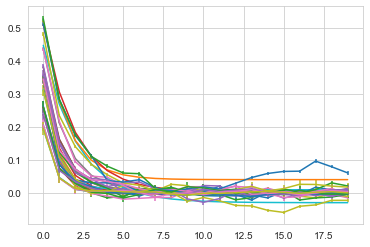

In [12]:
massesvec=[]
masserrvec=[]
xvec=[]
for i in range(len(fitvecsmasses)):
    xvec.append(i)
    [mass,masserr]=from_k_to_plot(i)
    massesvec.append(mass)
    masserrvec.append(masserr)

<ErrorbarContainer object of 3 artists>

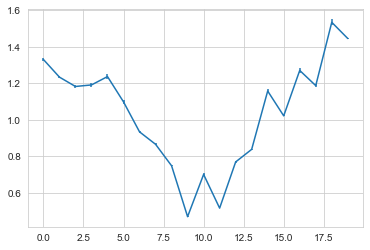

In [13]:
plt.errorbar(xvec,np.array(massesvec),yerr=masserrvec)

# Getting masses from the 2-pt function in momentum space

In [14]:
def get_2pc_mom(cfgsp,j):
    mean1=jackknife(cfgsp[:,0,j])
    mean2=jackknife(cfgsp[:,0,-j])
    errprod=np.sqrt(((mean1[0])**2)*((mean2[1])**2)+((mean2[0])**2)*((mean1[1])**2))
    totpart=jackknife(cfgsp[:,0,j]*cfgsp[:,0,-j])
    return [abs(totpart[0]-mean1[0]*mean2[0]),abs(np.sqrt(errprod**2+totpart[1]**2))]

In [15]:
def twoptfalloff(x, z, m2):
    return z *(1/(((x*x)/m2)+1))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[30.24438842969394, 23.982589871041384, 21.95273659240974, 18.20095010499735, 14.316434815636356, 11.44779755232717, 13.317801419717622, 7.350922345505513, 6.384038660208696, 3.021839046150067, 1.2721690987360603, 0.42457735948255804, 4.510457483330157, 7.842642825443379, 13.977925040393696, 20.619255254875256, 27.706614245690407, 29.6926047638525, 28.393068783867406, 40.957277488263465]


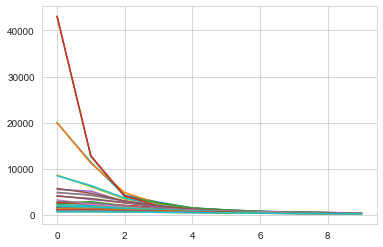

In [16]:
kvalues=load_k_values(os.getcwd()+'/tensors.h5')
fitvecsmasses=[]
i=0
for kval in kvalues:
    i+=1
    print(i)
    cgfstemp=load_tensor_for_k(os.getcwd()+'/tensors.h5', kval)
    cfgsp=np.fft.fftn(cgfstemp,axes=(1,2))
    twopcmom=[get_2pc_mom(cfgsp,j)[0] for j in range(10)]
    xarr=np.array(range(len(twopcmom)))
    [zfit, m2fit], pcov = curve_fit(twoptfalloff, np.array(range(len(twopcmom))), twopcmom, p0=[twopcmom[0],10])
    yarr=twoptfalloff(xarr, zfit, m2fit)
    fitvecsmasses.append(m2fit)
    plt.plot(xarr,twopcmom)
    plt.plot(xarr,yarr)

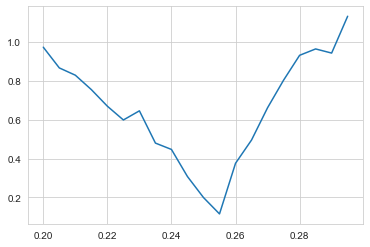

In [17]:
plt.plot(kvalues,np.sqrt(np.array(fitvecsmasses)/32))

In [2]:
print("a")

a
